## Firing rate changes in interneurons/pyramidal during SD

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from plotUtil import Fig
import subjects

In [ ]:
%matplotlib widget
figure = Fig()
fig,gs = figure.draw(grid=(1,1),size=(4,4))
sessions = subjects.Sd().allsess
data = pd.DataFrame()
for sub, sess in enumerate(sessions):
    pre = sess.epochs.pre
    post = sess.epochs.post
    sd_period = [post[0],post[0]+5*3600] 
    intneur = sess.spikes.intneur
    sd_bins = np.arange(post[0],post[0]+6*3600,3600)
    frate = np.asarray([np.histogram(cell,bins=sd_bins)[0] for cell in intneur])/3600
    # frate= np.log10(frate)
    mean_frate = np.mean(frate,axis=0)
    data = data.append(pd.DataFrame({'frate':frate.flatten(),'bins':list(np.arange(1,6))*frate.shape[0]}))

ax = plt.subplot(gs[0])
sns.boxplot(data=data,x='bins',y='frate',color='#ccc7c7',ax=ax)
# sns.swarmplot(data=data,x='bins',y='frate',color='k',ax=ax)
ax.set_xlabel('ZT (SD period)')
ax.set_title('Firing rating changes across sleep deprivation')





## Firing rate changes across session in SD and compare with NSD

Kamran's comment as observed from Miyawaki and Diba 2016 (Fig 1C)
> The animal is put on the track at 6am, and firing rates shoot up. In POST (next day’s light cycle) they start to come down. What happens to these firing rates in SD? In SD before Track, are they also high, or does it require TRack running?  And in NSD after track, do they come down, compared to SD after track?

The analysis below is for assesing that

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from plotUtil import Fig
import subjects


In [ ]:
%matplotlib widget
figure = Fig()
fig,gs = figure.draw(grid=(1,1),size=(4,4))
sessions = subjects.Sd().allsess + subjects.Nsd().allsess
data = pd.DataFrame()
for sub, sess in enumerate(sessions):

    tag = sess.recinfo.animal.tag
    try:
        maze = sess.epochs.maze
    except:
        maze = sess.epochs.maze1

    pre = sess.epochs.pre
    post = sess.epochs.post
    cells = sess.spikes.pyr

    pre_bins,pre_binsz = np.linspace(pre[0],pre[1],2,retstep=True)
    frate_pre = np.asarray([np.histogram(cell,bins=pre_bins)[0] for cell in cells])/pre_binsz

    maze_bins,maze_binsz = np.linspace(maze[0],maze[1],2,retstep=True)
    frate_maze = np.asarray([np.histogram(cell,bins=maze_bins)[0] for cell in cells])/maze_binsz

    sd_bins,sd_binsz = np.linspace(post[0],post[0]+5*3600,2,retstep=True)
    frate_sd = np.asarray([np.histogram(cell,bins=sd_bins)[0] for cell in cells])/sd_binsz


    post_bins,post_binsz = np.linspace(post[0]+5*3600,post[1],2,retstep=True)
    frate_post = np.asarray([np.histogram(cell,bins=post_bins)[0] for cell in cells])/post_binsz

    frate = np.hstack((frate_pre,frate_maze,frate_sd,frate_post))

    # frate= np.log10(frate)
    # mean_frate = np.mean(frate,axis=0)
    data = data.append(pd.DataFrame({'frate':frate.flatten(),'bins':list(np.arange(1,frate.shape[1]+1))*frate.shape[0]}))

data_mean = data.groupby('bins').mean()
data_sem = data.groupby('bins').sem(ddof=0)

ax = plt.subplot(gs[0])
# sns.lineplot(data=data,x='bins',y='frate',color='#ccc7c7',ax=ax,err_style='bars',ci=68)
ax.errorbar(data_mean.index.values,data_mean['frate'],yerr=data_sem['frate'],capsize=3,lw=2,color='k')
ax.axvspan(1,7,0,0.05,color='#968d8d')
ax.axvspan(7,16,0,0.05,color='#fadf80')
# ax.axvspan(7,16,0,0.05,color='#de5454')
# ax.axvspan(10,16,0,0.05,color='#de5454')
# sns.swarmplot(data=data,x='bins',y='frate',color='k',ax=ax)
ax.set_xlabel('ZT (SD period)')
ax.set_title('Firing rating changes across entire session')
ax.set_ylim([0.2,1])


In [ ]:
sess = subjects.Of().ratNday4[0]
sess.tracks.plot(['maze'])

## Pbe changes across sleep deprivation

In [ ]:
import numpy as np
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
)


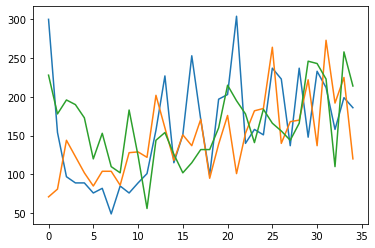

In [8]:
import matplotlib.pyplot as plt

for sess in sessions:

    # sd = sess.paradigm['sd']
    post = sess.paradigm['post']
    sd = [post[0],post[0]+5*3600]
    pbe_sd = sess.pbe.time_slice(sd[0],sd[1])

    sd_bin = np.arange(sd[0],sd[1],500)
    hist_pbe = np.histogram(pbe_sd.starts,bins=sd_bin)[0]
    plt.plot(hist_pbe)

In [7]:
print(sess.paradigm.to_dataframe())

   start   stop label  duration
0      0  11160   pre     11160
1  11185  15021  maze      3836
2  15146  56092  post     40946
